In [1]:
#!pip install fastai
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio
import seaborn as sns
from keras.models import Model
from sklearn.metrics import confusion_matrix
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import * 

In [2]:
data = pd.read_csv('./icml_face_data.csv')

In [3]:
print(data.shape)
data.head()

(35887, 3)


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
data['pixels'] = data[' pixels']

In [5]:
data['pixels'] = data['pixels'].apply (lambda x : x.split(' '))
data['pixels'] = data['pixels'].apply (lambda x : np.reshape(x, (48,48)))

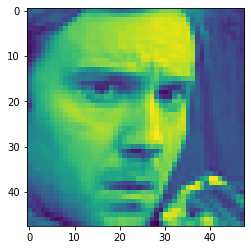

In [6]:
plt.imshow(data['pixels'][0].astype(float))

In [7]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [8]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [9]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [10]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

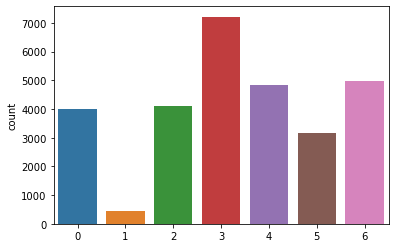

In [11]:
sns.countplot(train_image_label)

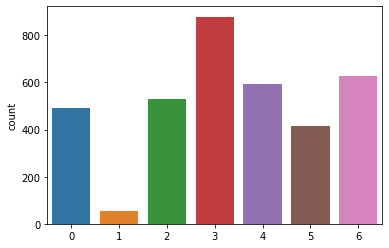

In [12]:
sns.countplot(val_image_label)

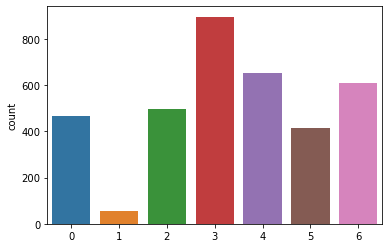

In [13]:
sns.countplot(test_image_label)

In [14]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [15]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )

In [16]:
#datagen.fit(x_train)

In [17]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(125, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(125, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))#
model.add(Conv2D(125, (3, 3), activation='relu'))#
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 125)       36125     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 125)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 125)         140750    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 125)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 125)         1

In [19]:
batch_size = 0.25*(len(train_images))

In [20]:
datagen.fit(train_images)

In [21]:
history = model.fit(datagen.flow(train_images , train_labels),
                    validation_data=datagen.flow(val_images, val_labels),
                    epochs=80,
                    class_weight = class_weight,
                    batch_size= batch_size)

Epoch 1/80
898/898 [==============================] - 39s 43ms/step - loss: 0.2844 - accuracy: 0.2579 - val_loss: 1.6256 - val_accuracy: 0.3664
Epoch 2/80
898/898 [==============================] - 38s 42ms/step - loss: 0.2370 - accuracy: 0.4009 - val_loss: 1.5129 - val_accuracy: 0.4366
Epoch 3/80
898/898 [==============================] - 36s 41ms/step - loss: 0.2163 - accuracy: 0.4575 - val_loss: 1.4039 - val_accuracy: 0.4817
Epoch 4/80
898/898 [==============================] - 38s 42ms/step - loss: 0.2045 - accuracy: 0.4846 - val_loss: 1.3516 - val_accuracy: 0.4921
Epoch 5/80
898/898 [==============================] - 36s 40ms/step - loss: 0.1997 - accuracy: 0.5016 - val_loss: 1.3684 - val_accuracy: 0.5007
Epoch 6/80
898/898 [==============================] - 36s 40ms/step - loss: 0.1956 - accuracy: 0.5156 - val_loss: 1.2774 - val_accuracy: 0.5255
Epoch 7/80
898/898 [==============================] - 37s 41ms/step - loss: 0.1897 - accuracy: 0.5304 - val_loss: 1.2407 - val_accuracy:

898/898 [==============================] - 35s 39ms/step - loss: 0.1556 - accuracy: 0.6113 - val_loss: 1.1213 - val_accuracy: 0.5929
Epoch 58/80
898/898 [==============================] - 35s 39ms/step - loss: 0.1544 - accuracy: 0.6137 - val_loss: 1.0880 - val_accuracy: 0.5929
Epoch 59/80
898/898 [==============================] - 36s 40ms/step - loss: 0.1551 - accuracy: 0.6199 - val_loss: 1.1242 - val_accuracy: 0.5968
Epoch 60/80
898/898 [==============================] - 35s 40ms/step - loss: 0.1548 - accuracy: 0.6144 - val_loss: 1.1329 - val_accuracy: 0.5876
Epoch 61/80
898/898 [==============================] - 35s 39ms/step - loss: 0.1534 - accuracy: 0.6179 - val_loss: 1.1175 - val_accuracy: 0.5865
Epoch 62/80
898/898 [==============================] - 35s 39ms/step - loss: 0.1555 - accuracy: 0.6131 - val_loss: 1.1195 - val_accuracy: 0.5935
Epoch 63/80
898/898 [==============================] - 35s 39ms/step - loss: 0.1529 - accuracy: 0.6158 - val_loss: 1.1575 - val_accuracy: 0.58

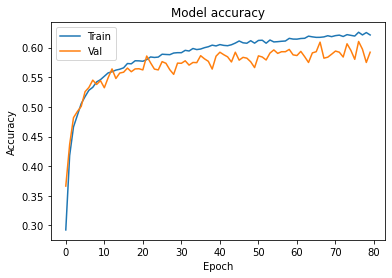

In [22]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

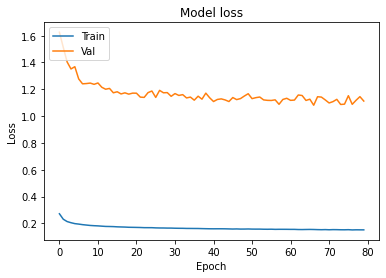

In [23]:
# Plot training and test loss
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Val'], loc='upper left') 
plt.show()